In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None)

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [ ]:
drive.mount('/content/drive')
PICKLE_PATH = "/content/drive/MyDrive/allocine_dataset.pickle"

Mounted at /content/drive


In [ ]:
import pickle
with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

# Used to train fit tokenizer
#all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

train_labels = data["train_set"]['polarity']
val_labels = data["val_set"]['polarity']
test_labels = data["test_set"]['polarity']
class_names = data['class_names']

In [ ]:
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 186308 unique tokens.


In [ ]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_reviews)
val_reviews_tokenized = tokenizer.texts_to_sequences(val_reviews)
test_reviews_tokenized = tokenizer.texts_to_sequences(test_reviews)

In [ ]:
some_review = train_reviews_tokenized[0]
some_review[:15]

[45, 68, 4664, 17, 77, 15081, 7, 80, 9, 8746, 2505, 249, 439, 17, 1181]

In [ ]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in some_review[:15]])

"si vous cherchez du cinéma abrutissant à tous les étages n'ayant aucune peur du cliché"

Average length: 91.5
Max length: 389


<ipython-input-12-7d458d2b527a>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))


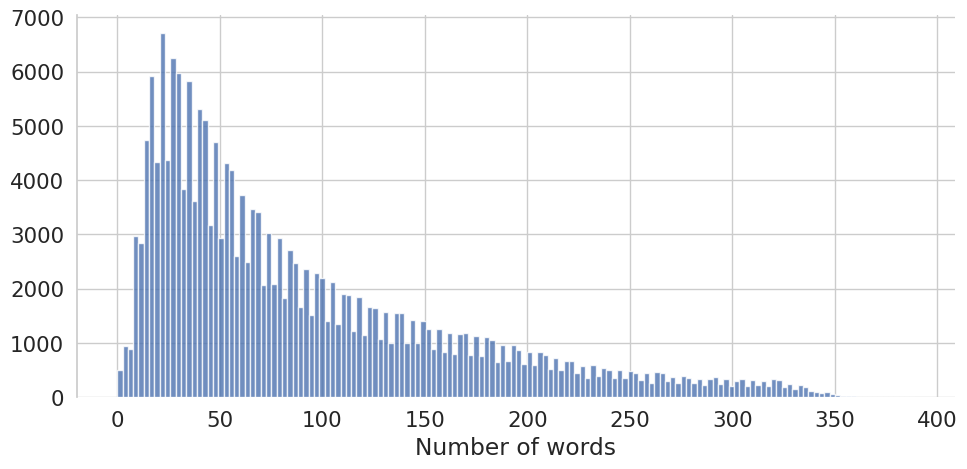

In [ ]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()

In [ ]:
def remove_empty_sequences(reviews, labels):
    reviews_not_empty = []
    labels_not_empty = []
    removed = 0
    for x, y in zip(reviews, labels):
        if len(x) > 0:
            reviews_not_empty.append(x)
            labels_not_empty.append(y)
        else:
            removed += 1
    #print("Removed {} sequences !".format(removed))
    return reviews_not_empty, labels_not_empty

In [ ]:
print('Removing {} empty sequences'.format(reviews_len.count(0)))

train_reviews_tokenized, train_labels = remove_empty_sequences(
    train_reviews_tokenized, train_labels
)

val_reviews_tokenized, val_labels = remove_empty_sequences(
    val_reviews_tokenized, val_labels
)

test_reviews_tokenized, test_labels = remove_empty_sequences(
    test_reviews_tokenized, test_labels
)

# Verify
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
assert(reviews_len.count(0) == 0)

Removing 8 empty sequences


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH_SEQ = 350 #

X_train = pad_sequences(
    train_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = pad_sequences(
    val_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = pad_sequences(
    test_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (159993, 350)
Shape of X_val tensor: (19999, 350)
Shape of X_test tensor: (20000, 350)


In [ ]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SequencePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_nbr_words, max_seq_length):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_nbr_words,
            oov_token="<unk>",
        )
        self.max_seq_length = max_seq_length

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X):
        self.tokenizer.fit_on_texts(X)

    def transform(self, X, y):
        # 1. Tokenize
        X_tokenized = self.tokenizer.texts_to_sequences(X)
        # 2. Remove empty sequences
        X_not_empty, y_not_empty = remove_empty_sequences(X_tokenized, y)
        # 3. Pad
        X_padded = tf.keras.preprocessing.sequence.pad_sequences(
            X_not_empty,
            maxlen=self.max_seq_length,
            padding='post'
        )
        # 4. labels
        y_array = np.array(y_not_empty)
        return X_padded, y_array

    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X, y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Hyperparameters
max_features = MAX_NB_WORDS
embedding_dim = 128

model = Sequential(name='fasttext')
model.add(Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
initial_weights = model.get_weights()
model.summary()

Model: "fasttext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2560129 (9.77 MB)
Trainable params: 2560129 (9.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/word-vectors/fasttext_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128,
    callbacks=[checkpointer], verbose=1)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8260
Epoch 1: val_loss improved from inf to 0.30024, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 69s 54ms/step - loss: 0.4702 - accuracy: 0.8260 - val_loss: 0.3002 - val_accuracy: 0.9057
Epoch 2/10
   1/1250 [..............................] - ETA: 1:31 - loss: 0.3575 - accuracy: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.9119
Epoch 2: val_loss improved from 0.30024 to 0.23153, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 75s 60ms/step - loss: 0.2558 - accuracy: 0.9119 - val_loss: 0.2315 - val_accuracy: 0.9186
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9265
Epoch 3: val_loss improved from 0.23153 to 0.21653, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 99s 79ms/step - loss: 0.2063 - accuracy: 0.9265 - val_loss: 0.2165 - val_accuracy: 0.9215
Epoch 4/10
1249/1250 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9328
Epoch 4: val_loss improved from 0.21653 to 0.20481, saving model to data/word-vectors/fasttext_weights.hdf5
1250/1250 [==============================] - 78s 62ms/step - loss: 0.1842 - accuracy: 0.9328 - val_loss: 0.2048 - val_accur

In [ ]:
!pip install utils

In [ ]:
from sklearn import metrics

probas = model.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

625/625 [==============================] - 3s 5ms/step
Val Accuracy: 92.68
Val F1-Score: 92.56


<ipython-input-25-61ed54258731>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (probas > 0.5).astype(np.int)


In [ ]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

probas = model.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)

625/625 [==============================] - 3s 5ms/step


<ipython-input-26-77ab8a97566c>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (probas > 0.5).astype(np.int)


In [ ]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred,
    target_names=class_names.values()
)
print(report)

Test Accuracy: 92.83
Test F1-Score: 92.49

              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93     10408
    Positive       0.93      0.92      0.92      9592

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [ ]:
model.load_weights('data/word-vectors/fasttext_weights.hdf5')

In [ ]:
import time

inference_times = []

for i in range(1000):
    x = np.array([X_test[i], ])
    start_time = time.time()
    y_pred = model.predict(x)
    stop_time = time.time()

    inference_times.append(stop_time - start_time)

1/1 [==============================] - 0s 21ms/step


In [ ]:
OUTPUT_PATH = 'data/word-vectors/fasttext_times.pickle'

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(inference_times, writer)